<a href="https://colab.research.google.com/github/Aashi779/LLM_Human_TextDetection/blob/main/LLM_Text_detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Summary:**
The objective of this notebook is to participate in 'LLM : Detect AI generated text' competition where using a dataset of prompts and texts generated by humans and AI, we have to predict which one is generated by an AI. First, we use different datasets and combine them to prepare a dataset which has classes balanced. then , we clean tha data by stemming(a text processing method that removes prefixes and suffixes from words to transform them into their root form.) the text, removing stopwords and punctuations. After this, we convert text into numbers by Count Vectorizer and then finally we train an ML model on the final vector and test it on validation dataset before predicting the results of test dataset. The results on using different ML models is documented in last cell.

Version 2 : with Daigt Dataset and with DistilBert (Failed) Version 3: with Daigt Subset and considering more Human Written Text vs AI Generated

In [2]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 24.9 MB/s eta 0:00:00


In [4]:
!pip install keras_nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 19.3 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
snowball = SnowballStemmer(language='english')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as XGB
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
from numba import cuda
from nltk.tokenize import word_tokenize
import tensorflow_text as tftext
import tensorflow_hub as tfhub
import keras_nlp
import keras
from keras import layers

Using TensorFlow backend


In [6]:
#loading the training csv file
train_csv_loc = "train_essays.csv"
train_csv = pd.read_csv(train_csv_loc)
train_csv

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [7]:
#Loading the prompts csv files
prompts_csv = "train_prompts.csv"
pd.read_csv(prompts_csv)


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


generated
0    1375
1       3
Name: text, dtype: int64


([<matplotlib.patches.Wedge at 0x7da0ed5f4730>,
 [Text(-1.0999742722741532, 0.0075233194101512945, 'generated by students'),
  Text(1.099974272477764, -0.007523289640464896, 'generated by LLM')],
 [Text(-0.5999859666949926, 0.004103628769173433, '99.78%'),
  Text(0.599985966806053, -0.00410361253116267, '0.22%')])

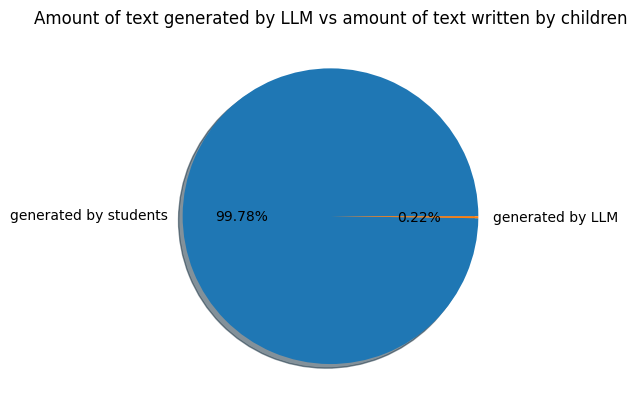

In [8]:
llm_generated_perc = train_csv.groupby('generated').count()['text']
print(llm_generated_perc)
plt.title("Amount of text generated by LLM vs amount of text written by children")
plt.pie(llm_generated_perc,labels=['generated by students','generated by LLM'],autopct = '%0.2f%%',shadow=True)

The above code shows extreme code imbalance

prompt_id
0    708
1    670
Name: generated, dtype: int64


([<matplotlib.patches.Wedge at 0x7da0eb3b8d30>,
 [Text(-0.04763336781987195, 1.0989681807359741, 'Car-free cities'),
  Text(0.047633367819872305, -1.0989681807359741, 'Does the electoral college work?')],
 [Text(-0.025981836992657426, 0.5994371894923495, '51.38%'),
  Text(0.025981836992657617, -0.5994371894923495, '48.62%')])

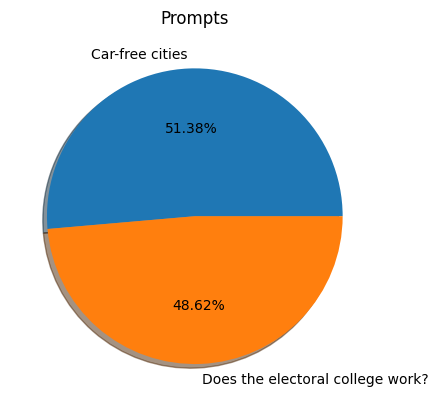

In [9]:
prompt_perc = train_csv.groupby('prompt_id').count()['generated']
print(prompt_perc)
plt.title("Prompts")
plt.pie(prompt_perc,labels=["Car-free cities","Does the electoral college work?"],autopct="%0.2f%%",shadow=True)

Adding new data to prevent class imbalance

In [12]:
dataset_1_loc ='Mistral7B_CME_v6.csv'
aug_data1 = pd.read_csv(dataset_1_loc)
aug_data1 = aug_data1[aug_data1["prompt_id"]==2]
aug_data1["prompt_id"]=aug_data1['prompt_id']-2
aug_data1
# 2-2 will be adding onto class label 0

,prompt_id,text,prompt_name,generated
3500,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3501,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3502,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3503,0,Car-free cities have become increasingly popu...,Car-free cities,1
3504,0,Car-free cities are a growing concept in toda...,Car-free cities,1
...,...,...,...,...
4195,0,The concept of car-free cities is becoming in...,Car-free cities,1
4196,0,Car-free cities: a vision for a healthier and...,Car-free cities,1
4197,0,The concept of car-free cities has gained pop...,Car-free cities,1
4198,0,Car-free cities are cities where cars are not...,Car-free cities,1


In [13]:
dataset_2_loc = 'Mistral7B_CME_v7.csv'
aug_data2 = pd.read_csv(dataset_2_loc)
aug_data2 = aug_data2[aug_data2["prompt_id"]==12]
aug_data2["prompt_id"]=aug_data2['prompt_id']-11
aug_data2
# 12-11 = 1 will be adding onto class label 1

,prompt_id,text,prompt_name,generated
4200,1,The electoral college is a system that is use...,Does the electoral college work?,1
4201,1,The electoral college system that is used to ...,Does the electoral college work?,1
4202,1,The electoral college is a system used in the...,Does the electoral college work?,1
4203,1,The electoral college is a system in which ci...,Does the electoral college work?,1
4204,1,The Electoral College is a system used in the...,Does the electoral college work?,1
...,...,...,...,...
4895,1,The electoral college is one of the most disc...,Does the electoral college work?,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",Does the electoral college work?,1
4897,1,The electoral college is a system that is use...,Does the electoral college work?,1
4898,1,A strong electoral system is vital to the fun...,Does the electoral college work?,1


In [14]:
aug_data_mistral = pd.concat([aug_data1,aug_data2],axis=0)
aug_data_mistral

,prompt_id,text,prompt_name,generated
3500,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3501,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3502,0,Car-free cities are becoming increasingly pop...,Car-free cities,1
3503,0,Car-free cities have become increasingly popu...,Car-free cities,1
3504,0,Car-free cities are a growing concept in toda...,Car-free cities,1
...,...,...,...,...
4895,1,The electoral college is one of the most disc...,Does the electoral college work?,1
4896,1,"Dear Sen. [Name],\n\nI am writing to express ...",Does the electoral college work?,1
4897,1,The electoral college is a system that is use...,Does the electoral college work?,1
4898,1,A strong electoral system is vital to the fun...,Does the electoral college work?,1


In [15]:
google_palm = pd.read_csv('LLM_generated_essay_PaLM.csv').drop(columns=['id'])
google_palm = google_palm.drop(columns=['prompt_id'])
google_palm

,text,generated
0,## The Advantages of Limiting Car Usage\n\nIn ...,1.0
1,"The United States is a car-dependent nation, w...",1.0
2,"In recent years, there has been a growing move...",1.0
3,"In recent years, there has been a growing move...",1.0
4,"In the past few decades, the United States has...",1.0
...,...,...
1379,"Dear Senator,\n\nI am writing to you today to ...",1.0
1380,"Dear Senator,\n\nI am writing to you today to ...",1.0
1381,"Dear Senator,\n\nI am writing to you today to ...",1.0
1382,"Dear Senator,\n\nI am writing to you today to ...",1.0


In [ ]:
big_set =pd.read_csv('final_train.csv')
big_set_0_4000 = big_set[big_set['label']==0].iloc[0:4000,:] #first 2000 rows of human written texts
big_set_1_2600 = big_set[big_set['label']==1].iloc[0:2600,:] #first 600 rows of AI written texts
big_set_0_4000

In [ ]:
big_set_6600 = pd.concat([big_set_0_4000,big_set_1_2600],axis=0)
big_set_6600.rename(columns={'label':'generated'},inplace=True)
big_set_6600

In [16]:
aug_data_mistral = aug_data_mistral.drop(columns= ['prompt_name','prompt_id'])
aug_data_mistral

,text,generated
3500,Car-free cities are becoming increasingly pop...,1
3501,Car-free cities are becoming increasingly pop...,1
3502,Car-free cities are becoming increasingly pop...,1
3503,Car-free cities have become increasingly popu...,1
3504,Car-free cities are a growing concept in toda...,1
...,...,...
4895,The electoral college is one of the most disc...,1
4896,"Dear Sen. [Name],\n\nI am writing to express ...",1
4897,The electoral college is a system that is use...,1
4898,A strong electoral system is vital to the fun...,1


In [ ]:
daigt_data = pd.read_csv('/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv')

In [ ]:
print("Column names in the dataset:", daigt_data.columns.tolist())

# If the 'generated' column is not found, we assume the original column name 'label' is still present.
# Let's use 'label' to check the distribution of labels (0 and 1).
label_column = 'label' if 'label' in daigt_data.columns else 'generated'
label_counts = daigt_data[label_column].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar')
plt.title('Number of Texts by Label')
plt.xlabel('Label')
plt.ylabel('Number of Texts')
plt.xticks([0, 1], ['Label 0', 'Label 1'], rotation=0)  # Set text labels for the x-axis
plt.show()

#the one with label 0 are Human written Text
#Label 1 : AI Generated Text

In [ ]:
daigt_data_0_4000 = daigt_data[daigt_data['label']==0].iloc[0:4000,:] #first 2000 rows of human written texts
daigt_data_1_2600 = daigt_data[daigt_data['label']==1].iloc[:2600,:] #first 600 rows of AI written texts
daigt_data_0_4000

In [ ]:
daigt_data_6600 = pd.concat([daigt_data_0_4000,daigt_data_1_2600],axis=0)
daigt_data_6600.rename(columns={'label':'generated'},inplace=True)
daigt_data_6600

In [ ]:
# Drop the specified columns
columns_to_drop = ['prompt_name', 'source', 'RDizzl3_seven']
daigt_data_6600.drop(columns=columns_to_drop, inplace=True, errors='ignore')  # errors='ignore' in case columns don't exist

# Rename the 'label' column to 'generated'
daigt_data_6600.rename(columns={'label': 'generated'}, inplace=True)

In [ ]:
daigt_data_6600

Dropped prompt name column as it was unnecessary because prompt ID is already given

In [17]:
train_csv= train_csv.drop(columns=['id','prompt_id'])
train_csv

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
1373,There has been a fuss about the Elector Colleg...,0
1374,Limiting car usage has many advantages. Such a...,0
1375,There's a new trend that has been developing f...,0
1376,As we all know cars are a big part of our soci...,0


Dropped id column as it is not necessary for training and also to concatenate with new dataset.
prompt_id dropped because prompt_id column wasn't there in the biggest dataset posing a problem in concatenating.

Final data to be used

In [ ]:
final_data = pd.concat([train_csv,aug_data_mistral,big_set_6600,google_palm,daigt_data_6600],axis=0)
final_data

In [18]:
final_data = pd.concat([train_csv,aug_data_mistral,google_palm],axis=0)
final_data

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
1379,"Dear Senator,\n\nI am writing to you today to ...",1.0
1380,"Dear Senator,\n\nI am writing to you today to ...",1.0
1381,"Dear Senator,\n\nI am writing to you today to ...",1.0
1382,"Dear Senator,\n\nI am writing to you today to ...",1.0


In [19]:
final_data['text'].index = np.arange(0,final_data.shape[0])
final_data['text']

0       Cars. Cars have been around since they became ...
1       Transportation is a large necessity in most co...
2       "America's love affair with it's vehicles seem...
3       How often do you ride in a car? Do you drive a...
4       Cars are a wonderful thing. They are perhaps o...
                              ...                        
4157    Dear Senator,\n\nI am writing to you today to ...
4158    Dear Senator,\n\nI am writing to you today to ...
4159    Dear Senator,\n\nI am writing to you today to ...
4160    Dear Senator,\n\nI am writing to you today to ...
4161    Dear Senator,\n\nI am writing to you today to ...
Name: text, Length: 4162, dtype: object

In [20]:
final_data = final_data.drop_duplicates()
final_data

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0
...,...,...
1379,"Dear Senator,\n\nI am writing to you today to ...",1.0
1380,"Dear Senator,\n\nI am writing to you today to ...",1.0
1381,"Dear Senator,\n\nI am writing to you today to ...",1.0
1382,"Dear Senator,\n\nI am writing to you today to ...",1.0


([<matplotlib.patches.Wedge at 0x7da0ed6dffa0>,
 [Text(0.5588445836244674, 0.9474664803324684, 'generated by AI'),
  Text(-0.5588445836244678, -0.9474664803324683, 'not generated by AI')],
 [Text(0.30482431834061857, 0.5167998983631645, '33.04%'),
  Text(-0.30482431834061874, -0.5167998983631644, '66.96%')])

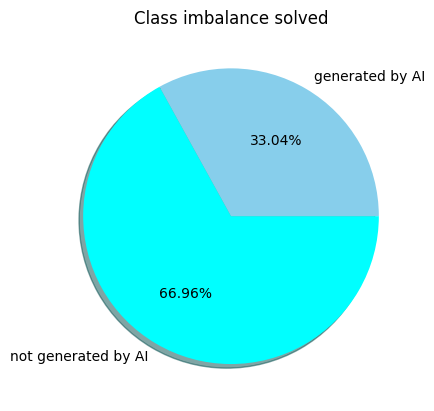

In [21]:
classes = final_data.groupby('generated').count()['text']
plt.title('Class imbalance solved')
plt.pie(classes, labels=['generated by AI','not generated by AI'],colors=['skyblue','cyan'],shadow=True,autopct='%0.2f%%')

In [22]:
def cleantext(data) :
    stemtext = []
    len_text = []
    para = data['text'].tolist()
    for paragraph in para:
        char = [char for char in paragraph if char not in string.punctuation]
        word = "".join(char).split(" ")
        words = [word.lower() for word in word if word not in stopwords.words('english')]
        stemwords = [SnowballStemmer('english').stem(word) for word in words]
        len_text.append(len(stemwords))
        stemtext.append(" ".join(stemwords))
    return stemtext , len_text

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
traintext = cleantext(final_data)[0]
traintext

['car car around sinc becam famous 1900s henri ford creat built first modelt car play major role everi day live sinc but peopl start question limit car usag would good thing to limit use car might good thing do\n\nin like matter articl in german suburb life goe on without car elizabeth rosenth state automobil linchpin suburb middl class famili either shanghai chicago tend make home expert say huge impedi current effort reduc greenhous gas emiss tailpip passeng car respons 12 percent greenhous gas emiss europeand 50 percent carintens area unit state car main reason greenhous gas emiss lot peopl drive around time get need go articl pari ban drive due smog robert duffer say pari day nearrecord pollut enforc partial drive ban clear air global citi it also say monday motorist evennumb licens plate order leav car home fine 22euro fine 31 the order would appli oddnumb plate follow day car reason pollut entir citi like pari this show bad car pollut caus entir city\n\nlikewis articl carfre day 

In [25]:
np.mean(cleantext(final_data)[1])

256.2424315233061

Average length of essays after cleaning the dataset is 256 words

In [26]:
x_train, x_test ,y_train , y_test = train_test_split(final_data.iloc[:,0:2], final_data['generated'],test_size=0.2)
x_train['labels'] = y_train
x_test['labels'] = y_test

In [27]:
x_train

,text,generated,labels
1192,"Dear Senator, Keeping the electoral college wo...",0.0,0.0
3693,The concept of car-free cities is becoming mo...,1.0,1.0
3805,Car-free cities are becoming increasingly pop...,1.0,1.0
1164,"Dear Senator,\n\nI am writing to you today to ...",1.0,1.0
4683,The electoral college is a system used in the...,1.0,1.0
...,...,...,...
564,Cars have become an indispensable part of our ...,1.0,1.0
4543,"Yes, the electoral college works as intended....",1.0,1.0
619,"Dear State Senator, The Electoral College is w...",0.0,0.0
1160,"Ai one poini, I believed ihe elecioral college...",0.0,0.0


In [28]:
x_test

,text,generated,labels
1061,"Dear Senator,\n\nI am writing to you today to ...",1.0,1.0
953,Imagine constantly coughing. Would you like th...,0.0,0.0
4024,The idea of car-free cities is becoming incre...,1.0,1.0
689,Cars have been around for over hundred years. ...,0.0,0.0
487,"In recent years, there has been a growing move...",1.0,1.0
...,...,...,...
1320,"Dear Senator,\n\nI am writing to you today to ...",1.0,1.0
4220,"Dear Senator,\n\nAs a concerned citizen of th...",1.0,1.0
684,All of these articles share the central idea o...,0.0,0.0
590,## Limiting Car Usage: The Advantages\n\nCars ...,1.0,1.0


In [29]:
y_train

1192    0.0
3693    1.0
3805    1.0
1164    1.0
4683    1.0
       ... 
564     1.0
4543    1.0
619     0.0
1160    0.0
265     1.0
Name: generated, Length: 3329, dtype: float64

In [30]:
y_test

1061    1.0
953     0.0
4024    1.0
689     0.0
487     1.0
       ... 
1320    1.0
4220    1.0
684     0.0
590     1.0
508     0.0
Name: generated, Length: 833, dtype: float64

In [31]:
#APPLY MODEL
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = tfhub.KerasLayer(
    "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3")
encoder_inputs = preprocessor(text_input)
encoder = tfhub.KerasLayer(
    "https://www.kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/bert-en-uncased-l-10-h-512-a-8/versions/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
sequence_output = outputs["sequence_output"]

dense_1 = tf.keras.layers.Dense(128 , activation='relu')(pooled_output)
dropout = tf.keras.layers.Dropout(0.7 , name="dropout1")(pooled_output)
dense_2 = tf.keras.layers.Dense(64 , activation='relu')(dropout)
dropout1 = tf.keras.layers.Dropout(0.5 , name="dropout2")(dense_2)
dense_3 = tf.keras.layers.Dense(16,activation='relu')(dropout1)

dense_out = tf.keras.layers.Dense(1 , activation='sigmoid', name='output')(dropout1)


model = tf.keras.Model(inputs=text_input, outputs=dense_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['input_1[0][0]']             
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.00005),
              loss='binary_crossentropy',
              metrics=["accuracy"])
metric = 'val_accuracy'
checkpoint_filepath = 'checkpoint.hdf5'
callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                    monitor=metric,
                                                    verbose=2,
                                                    save_best_only=True,
                                                    mode='max'),
                 tf.keras.callbacks.EarlyStopping(monitor=metric,
                                                  patience=0,
                                                  restore_best_weights=True)
                ]
history = model.fit(x_train['text'], x_train['labels'] , batch_size=8,
                    epochs=1 , validation_data=(x_test['text'], x_test['labels']))
model.save("bertmodel_v2")

417/417 [==============================] - 100s 152ms/step - loss: 0.1755 - accuracy: 0.9297 - val_loss: 0.0270 - val_accuracy: 0.9940


In [33]:
final_test = pd.read_csv('test_essays.csv')
final_test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [34]:
test_text = cleantext(final_test)[0]
test_text


['aaa bbb ccc', 'bbb ccc ddd', 'ccc ddd eee']

In [35]:
final_test['text'] = test_text

Prediction

In [36]:
pred = model.predict(final_test['text'].values)
pred

1/1 [==============================] - 1s 784ms/step


array([[0.11308277],
       [0.07444846],
       [0.05714239]], dtype=float32)

In [37]:
test_result = pred[:,0]
test_result

array([0.11308277, 0.07444846, 0.05714239], dtype=float32)

In [38]:
final_submission = pd.DataFrame(final_test['id'])
final_submission['generated'] = test_result
final_submission

,id,generated
0,0000aaaa,0.113083
1,1111bbbb,0.074448
2,2222cccc,0.057142


In [39]:
final_submission.to_csv('submission.csv', index=False)